In [7]:
import torch
import torchvision
from torchvision import transforms
from torch.nn import functional as f
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import collections
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from moco_model import MoCo
import time


In [13]:
class HistoryRecorder:
    def __init__(self, names, structure=None):
        if structure:
            if len(names) != len(structure):
                raise IndexError('The length of names and the length of structure should be equal')
            self.data = {name: s() for name, s in zip(names, structure)}
        else:
            self.data = {name: [] for name in names}
        self.names = names
        self.structure = structure

    def add(self, *args):
        if len(self.names) < len(args):
            raise IndexError('Too much values to record')
        else:
            for i in range(min(len(self.names), len(args))):
                if isinstance(self.data[self.names[i]], list):
                    self.data[self.names[i]].append(args[i])
                elif isinstance(self.data[self.names[i]], dict):
                    for k, v in args[i].items():
                        if k not in self.data[self.names[i]]:
                            self.data[self.names[i]][k] = [v]
                        else:
                            self.data[self.names[i]][k].append(v)

    def reset(self):
        if self.structure:
            self.data = {name: s() for name, s in zip(names, self.structure)}
        else:
            self.data = {name: [] for name in names}

    def __getitem__(self, name):
        return self.data[name]

def cal_accuracy_top_k(preds, label, top_k=(1, )):
    result = []
    max_k = max(top_k)
    sample_num = preds.shape[0]
    pred_scores, pred_labels = preds.topk(max_k, dim=1)
    pred_labels = pred_labels.t()
    correct = pred_labels.eq(label.view(1, -1).expand_as(pred_labels))
    for k in top_k:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        result.append(correct_k.item())
    return result

def image_pair_matching(net, original_image, matching_image):
    net.eval()
    q = net.encoder_q(original_image)
    q = f.normalize(q, dim=1)
    k = net.encoder_k(matching_image)
    k = f.normalize(k, dim=1)
    logits = torch.einsum('nc,ck->nk', [q, k.T])
    return logits

def train_moco_return_metrics_top_k(net, criterion, optimizer, epochs, device, k_candidates):
    train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], [list, dict, list, dict])
    to_tensor_func = torchvision.transforms.ToTensor()
    target_tensor = []
    for i in range(1, 185):
        target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
    target_tensor = torch.cat(target_tensor, dim=0)
    target_tensor = target_tensor.cuda(device)
    for epoch in range(epochs):
        net.cuda(device)
        total_loss = 0
        training_correct = collections.defaultdict(int)
        training_size = 0
        for origin, target, label in train_iter:
            net.train()
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target)
            loss = criterion(output, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net.eval()
            with torch.no_grad():
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    training_correct[k] += correct
                training_size += origin.shape[0]
        net.eval()
        with torch.no_grad():
            val_loss = 0
            val_correct = collections.defaultdict(int)
            for origin, target, label in val_iter:
                origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
                output, labels = net(origin, target, evaluate=True)
                val_loss += f.cross_entropy(output, labels).item()
                for k, correct in zip(k_candidates, cal_accuracy_top_k(image_pair_matching(net, origin, target_tensor), label, top_k=k_candidates)):
                    val_correct[k] += correct
        val_acc = {k: correct / origin.shape[0] for k, correct in val_correct.items()}
        train_acc = {k: correct / training_size for k, correct in training_correct.items()}
        train_metrics.add(total_loss / len(train_iter), train_acc, val_loss / len(val_iter), val_acc)
        print(f'Epoch {epoch + 1}, Train_Loss {total_loss / len(train_iter)}, Val_loss {val_loss / len(val_iter)}')
        for k, acc in train_acc.items():
            print(f'Train_acc_top_{k} {round(acc, 2)}', end='\t')
        print()
        for k, acc in val_acc.items():
            print(f'Val_acc_top_{k} {round(acc, 2)}', end='\t')
        print()
    return train_metrics

def draw_graph(metrics, num_epochs, k_candidates):
    def fmts_gen():
        line_styles = ['-', ':', '--', '-.']
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'w']
        for color in colors:
            for line_style in line_styles:
                yield color + line_style

    fmts = fmts_gen()
    X = [np.arange(1, num_epochs + 1, 1) for _ in range(2 * len(k_candidates))]
    fig, axes = plt.subplots((len(metrics.keys()) + 1) // 2, 1, figsize=(30, 10))
    if hasattr(axes, 'flatten'):
        axes = axes.flatten()
    else:
        axes = [axes]
    names = [f'Train Acc Top {k}' for k in k_candidates] + [f'Val Acc Top {k}' for k in k_candidates]
    plot_data = {k: list(metrics[k]['Train Acc'].values()) + list(metrics[k]['Val Acc'].values()) for k in metrics.keys()}
    for i, k in enumerate(metrics.keys()):
        for x, y, fmt in zip(X, list(plot_data.values())[0], fmts):
            axes[i].plot(x, y, fmt)
        axes[i].set_xlabel('Epochs')
        axes[i].set_xlim([0, num_epochs + 1])
        axes[i].set_ylim([0, 1])
        axes[i].legend(names)
        axes[i].grid()
        axes[i].set_title(f'Training result when k = {k}')
    plt.show()

In [18]:
def split_train_validation_randomly(original_path, target_path):
    original_images = list(sorted(list(map(str, list(Path(original_path).glob('*.jpg'))))))
    target_images = list(sorted(list(map(str, list(Path(target_path).glob('*.jpg'))))))
    images = list(zip(original_images, target_images))
    train_images, val_images = torch.utils.data.random_split(images, [160, 24])
    return train_images, val_images

class ThreeChannelNDIDatasetContrastiveLearningWithAug(Dataset):
    def __init__(self, images, evaluate=False):
        super(ThreeChannelNDIDatasetContrastiveLearningWithAug, self).__init__()
        if not evaluate:
            self.images = images[0]
        else:
            self.images = images[1]
        # 水平翻转 + 随机旋转 训练慢（100）但是效果好
        self.transforms = transforms.Compose([
            # transforms.GaussianBlur(kernel_size=3, sigma=0.7),
            # transforms.CenterCrop(150),
            # transforms.Resize(200),
            # transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(30)
            ])
        self.evaluate = evaluate

    def __getitem__(self, idx):
        origin_path, target_path = self.images[idx]
        origin = Image.open(origin_path).convert('RGB')
        target = Image.open(target_path)
        if not self.evaluate:
            origin, target = self.transforms(torch.cat((transforms.ToTensor()(origin).unsqueeze(0), transforms.ToTensor()(target).unsqueeze(0)), dim=0))
        else:
            origin, target = transforms.ToTensor()(origin), transforms.ToTensor()(target)
        label = int(origin_path.split('\\')[-1].split('.')[0]) - 1
        return origin, target, label

    def __len__(self):
        return len(self.images)

In [19]:
ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed/circle_binaryzation_pics'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/'
k_values = [48]
top_k_candidates = (10, 20, 30)
images = split_train_validation_randomly(ORIGINAL_IMAGE, TARGET_IMAGE)
train_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, False)
val_dataset = ThreeChannelNDIDatasetContrastiveLearningWithAug(images, True)
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
metrics = {}
for k in k_values:
    model = MoCo(torchvision.models.resnet18, dim=512, K=k, model_type='resnet', pretrained=True, three_channel=True)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics_top_k(model, criterion, optimizer, 50, device, top_k_candidates)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)

Epoch 1, Train_Loss 3.4319420077605174, Val_loss 4.370969295501709
Train_acc_top_10 0.04	Train_acc_top_20 0.12	Train_acc_top_30 0.2	
Val_acc_top_10 0.12	Val_acc_top_20 0.17	Val_acc_top_30 0.17	
Epoch 2, Train_Loss 3.8713782787323, Val_loss 4.388139724731445
Train_acc_top_10 0.04	Train_acc_top_20 0.11	Train_acc_top_30 0.2	
Val_acc_top_10 0.04	Val_acc_top_20 0.08	Val_acc_top_30 0.17	
Epoch 3, Train_Loss 3.6899520635604857, Val_loss 3.495112657546997
Train_acc_top_10 0.04	Train_acc_top_20 0.08	Train_acc_top_30 0.12	
Val_acc_top_10 0.04	Val_acc_top_20 0.21	Val_acc_top_30 0.21	
Epoch 4, Train_Loss 3.4893131971359255, Val_loss 3.587373733520508
Train_acc_top_10 0.06	Train_acc_top_20 0.11	Train_acc_top_30 0.17	
Val_acc_top_10 0.12	Val_acc_top_20 0.25	Val_acc_top_30 0.29	
Epoch 5, Train_Loss 3.3785370588302612, Val_loss 3.75921368598938
Train_acc_top_10 0.09	Train_acc_top_20 0.18	Train_acc_top_30 0.22	
Val_acc_top_10 0.08	Val_acc_top_20 0.21	Val_acc_top_30 0.29	
Epoch 6, Train_Loss 3.028026604

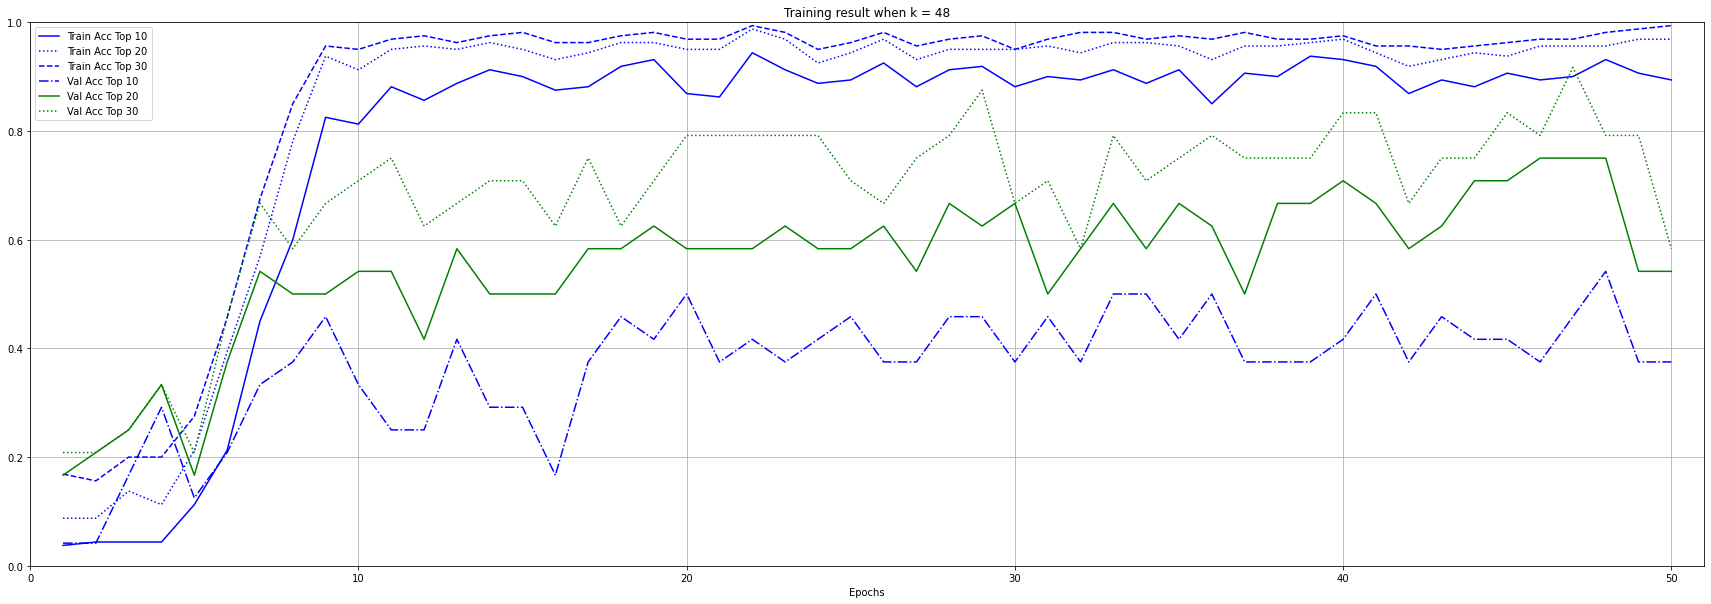

In [15]:
draw_graph(metrics, 50, top_k_candidates)